In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt


In [2]:
image_dir = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/train_data'
label_file = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/train_labels.txt'



In [3]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]  
        self.labels = self.load_labels(label_file)
    
    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f]  
        return labels
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
dataset = ImageDataset(image_dir=image_dir, label_file=label_file, transform=transforms.ToTensor())

In [5]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

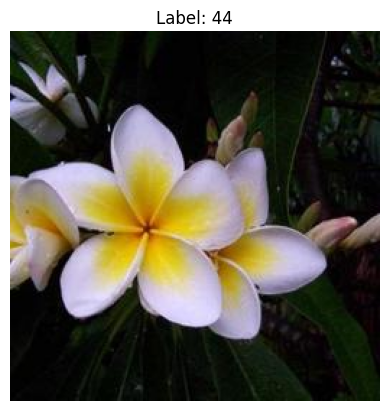

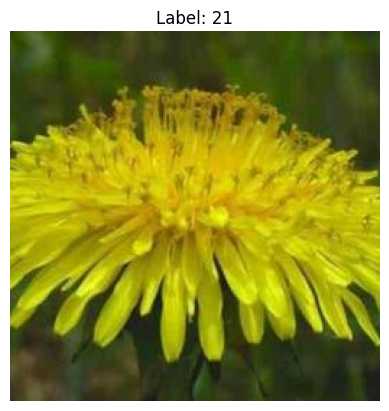

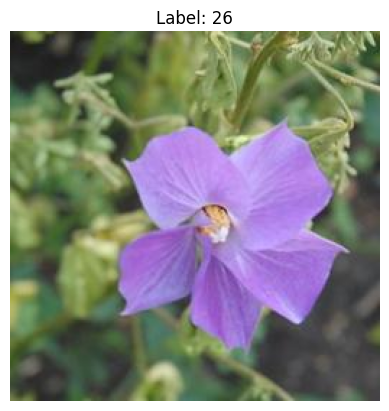

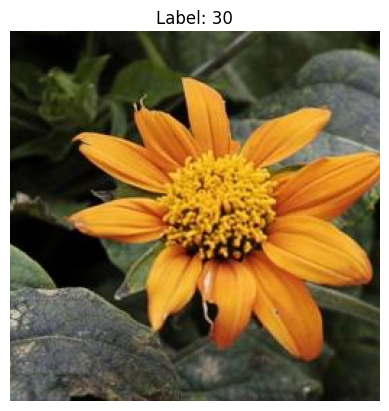

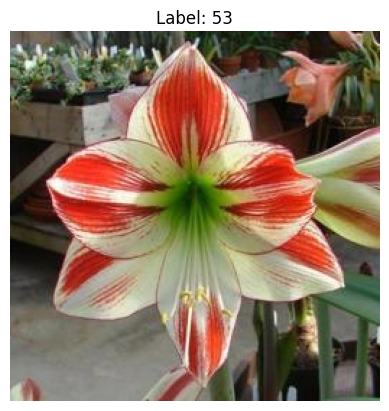

In [6]:
for images, labels in dataloader:
    # Convert the first 5 images back to PIL images and display them
    for i in range(5):  # Display 5 images
        img = transforms.ToPILImage()(images[i])  # Convert tensor to PIL image
        plt.figure()
        plt.title(f'Label: {labels[i].item()}')  # Display the label
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
    break

In [7]:
def flatten_images(dataloader):
    all_images = []
    for images, _ in dataloader:
        flattened = images.view(images.size(0), -1)
        all_images.append(flattened)
    return torch.cat(all_images, dim=0)

flattened_images = flatten_images(dataloader)
images_np = flattened_images.numpy()

In [8]:
from sklearn.decomposition import PCA
n_components=100
pca = PCA(n_components=n_components)
pca.fit(images_np)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

In [358]:
class CleanDataset(Dataset):
    def __init__(self, reduced_images, label_file, transform = None):
        self.reduced_images = reduced_images
        self.labels = self.load_labels(label_file)

    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f]  
        return labels

    def __len__(self):
        return len(self.reduced_images)
    
    def __getitem__(self, idx):
        reduced_image = self.reduced_images[idx]
        label = self.labels[idx]
        return reduced_image, label

In [359]:
#train_dataset = CleanDataset(reduced_images = reduced_images, label_file = label_file, transform=None)

In [360]:
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [18]:
image_dir2 = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/val_data'
label_file2 = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/val_labels.txt'

In [19]:
dataset2 = ImageDataset(image_dir=image_dir2, label_file=label_file2, transform=transforms.ToTensor())
valloader = DataLoader(dataset2, batch_size=8, shuffle=True)

In [363]:
#lattened_images2 = flatten_images(dataloader2)
#images_np2 = flattened_images2.numpy()

In [364]:
#reduced_images2 = pca.transform(images_np2)

In [365]:
#print(reduced_images2.shape)

(600, 100)


In [366]:
#torch.save(reduced_images2, "/Users/shreyasmishra/Desktop/PCA_valdata.pt")

In [14]:
#model
import torch.nn as nn

class ANN(nn.Module):
    def __init__(self,insize,num_class,dropout):
        super().__init__()
        self.insize=insize
        self.num_class=num_class
        
        self.fc1=nn.Linear(insize,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,128)
        self.fc4=nn.Linear(128,num_class)

        self.relu=nn.LeakyReLU()
        self.dropout=nn.Dropout(dropout)

    def forward(self,x):
        out=self.relu(self.fc1(x))
        out=self.dropout(self.relu(self.fc2(out)))
        out=self.dropout(self.relu(self.fc3(out)))
        out=self.fc4(out)
        return out

In [368]:
val_dataset = CleanDataset(reduced_images = reduced_images2, label_file = label_file2, transform = None)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [15]:
train_insize = n_components
num_class = 60
dropout = 0.0
lr = 0.001
loss = nn.CrossEntropyLoss()
model = ANN(train_insize, num_class, dropout)
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

In [22]:
num_epochs = 200
run = 0
for epoch in range(num_epochs):
    t_loss=0.0
    v_loss=0.0
    model.train()
    for i, (images, labels) in enumerate(dataloader):
        images=images.numpy().reshape(images.size(0),-1)
        images = pca.transform(images)
        optimizer.zero_grad()
        output = model(torch.tensor(images))
        compute_loss = loss(output, labels-1)
        t_loss+=compute_loss.item()
        compute_loss.backward()
        optimizer.step()
        run += 1

        if (epoch + 1) % 10 == 0:
            accurate = 0
            total = 0
            accuracy_score = 0
            for images, labels in valloader:
                images=images.numpy().reshape(images.size(0),-1)
                images = pca.transform(images)
                output = model(images)
                #print(output.shape)
                output=torch.round(nn.functional.softmax(output,dim=0))
                #print(output)
                total += labels.size(0)
                accurate+= (predicted == labels-1).sum()
                accuracy_score = 100 * accurate/total
            
    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(epoch, t_loss/run, accuracy_score))



NameError: name 'accuracy_score' is not defined

In [232]:
class CNNDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]  
        self.labels = self.load_labels(label_file)
    
    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f]  
        return labels
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            image=image.reshape(3,256,256)
        
        return image, label

cnn_set=CNNDataset(image_dir,label_file,transforms.ToTensor())
cnn_loader=DataLoader(cnn_set,batch_size=8,shuffle=True)
cnn_valset=CNNDataset(image_dir2,label_file2,transforms.ToTensor())
cnn_valloader=DataLoader(cnn_valset,batch_size=1,shuffle=True)

CNN=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=2),
                    nn.BatchNorm2d(num_features=6),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=6,out_channels=6,kernel_size=3,stride=1),
                    nn.BatchNorm2d(num_features=6),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Flatten(),
                    nn.Linear(5400,1024),
                    nn.ReLU(),
                    nn.Linear(1024,512),
                    nn.ReLU(),
                    nn.Linear(512,256),
                    nn.ReLU(),
                    nn.Linear(256,60)
                    )

In [233]:
train_insize = reduced_images.shape[1]
num_class = 60
dropout = 0.0
lr = 0.001
loss = nn.CrossEntropyLoss()
model2=CNN
optimizer2 = torch.optim.SGD(model2.parameters(), lr = lr)

num_epochs = 200
run = 0
for epoch in range(num_epochs):
    t_loss=0.0
    v_loss=0.0
    model2.train()
    for i, (images, labels) in enumerate(cnn_loader):
        
        optimizer2.zero_grad()
        output = model2(images)
        compute_loss = loss(output, labels-1)
        t_loss+=compute_loss.item()
        compute_loss.backward()
        optimizer2.step()
        run += 1

        if (epoch + 1) % 10 == 0:
            accurate = 0
            total = 0
            for images, labels in cnn_valloader:
                output = model2(images)
                #print(output.shape)
                output=torch.round(nn.functional.softmax(output,dim=0))
                #print(output)
                total += labels.size(0)
                accurate+= (predicted == labels-1).sum()
                accuracy_score = 100 * accurate/total
            
    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(epoch, t_loss/run, accuracy_score))



Iteration: 0. Loss: 4.0945328458150225. Accuracy: 13.333333015441895
Iteration: 1. Loss: 2.0426745160420734. Accuracy: 13.333333015441895
Iteration: 2. Loss: 1.358177076127794. Accuracy: 13.333333015441895
Iteration: 3. Loss: 1.01526300573349. Accuracy: 13.333333015441895
Iteration: 4. Loss: 0.8084174025217692. Accuracy: 13.333333015441895
Iteration: 5. Loss: 0.6691651540332371. Accuracy: 13.333333015441895
Iteration: 6. Loss: 0.5675323299226307. Accuracy: 13.333333015441895
Iteration: 7. Loss: 0.48825736045837403. Accuracy: 13.333333015441895
Iteration: 8. Loss: 0.42261036646807637. Accuracy: 13.333333015441895


KeyboardInterrupt: 